Using device: cuda
Loading MNIST dataset...
Starting training...
Epoch [1/50], Step [100/1094], Loss D: 1.3628, Loss G: 0.6693
Epoch [1/50], Step [200/1094], Loss D: 1.3391, Loss G: 0.7345
Epoch [1/50], Step [300/1094], Loss D: 1.2718, Loss G: 0.8024
Epoch [1/50], Step [400/1094], Loss D: 1.3780, Loss G: 0.9710
Epoch [1/50], Step [500/1094], Loss D: 1.3579, Loss G: 1.0807
Epoch [1/50], Step [600/1094], Loss D: 1.3764, Loss G: 0.8414
Epoch [1/50], Step [700/1094], Loss D: 1.2207, Loss G: 0.9115
Epoch [1/50], Step [800/1094], Loss D: 1.3251, Loss G: 0.7707
Epoch [1/50], Step [900/1094], Loss D: 1.0465, Loss G: 1.0748
Epoch [1/50], Step [1000/1094], Loss D: 1.3178, Loss G: 0.8415
Epoch [2/50], Step [100/1094], Loss D: 1.1072, Loss G: 0.9771
Epoch [2/50], Step [200/1094], Loss D: 1.6236, Loss G: 0.9651
Epoch [2/50], Step [300/1094], Loss D: 1.2796, Loss G: 0.8937
Epoch [2/50], Step [400/1094], Loss D: 1.2725, Loss G: 0.8223
Epoch [2/50], Step [500/1094], Loss D: 1.2494, Loss G: 0.8650
Epoc

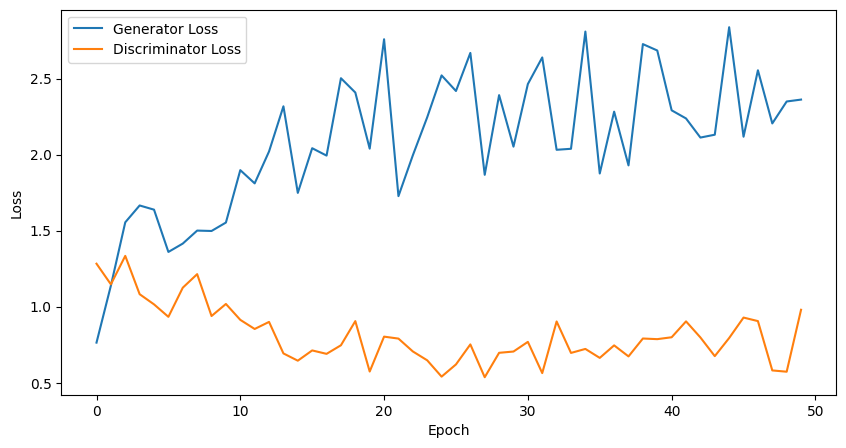

Training complete, generating final output...


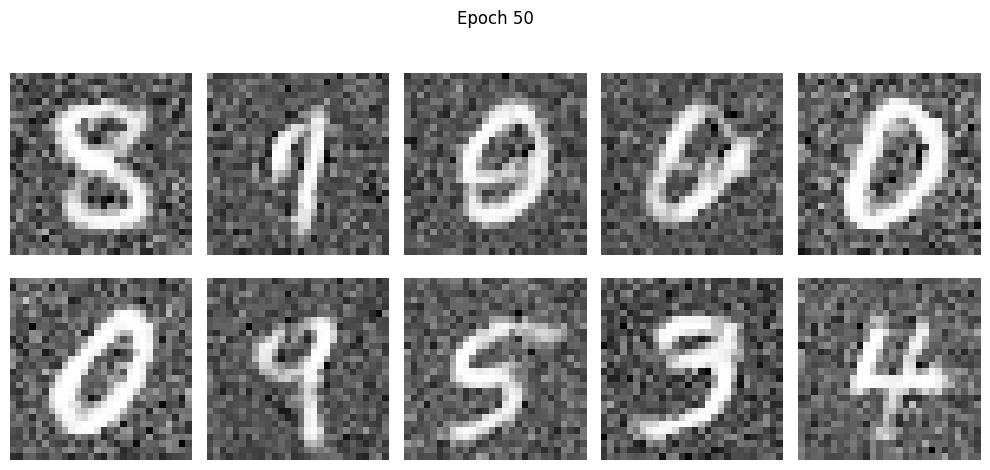

Models saved!


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
latent_dim = 100  # Dimension of the latent space
batch_size = 64
epochs = 50
lr = 0.0002
beta1 = 0.5  # Adam optimizer parameter

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load MNIST data from sklearn
print("Loading MNIST dataset...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')

# Normalize and reshape
X = X.astype('float32') / 255.0
X = X.values.reshape(-1, 1, 28, 28)  # Reshape to [N, C, H, W]

# Convert to PyTorch tensors - EXPLICITLY SET THE DATA TYPE to float32
X_tensor = torch.tensor(X, dtype=torch.float32)

# Create dataloader
mnist_dataset = TensorDataset(X_tensor)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # First layer
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),

            # Second layer
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            # Third layer
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            # Output layer
            nn.Linear(1024, 784),  # 28*28 = 784
            nn.Tanh()  # Output between -1 and 1
        )

    def forward(self, z):
        # Generate images from noise
        img = self.model(z)
        img = img.view(-1, 1, 28, 28)  # Reshape to image dimensions
        return img

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # First layer
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Second layer
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Output layer
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output probability between 0 and 1
        )

    def forward(self, img):
        img_flat = img.view(-1, 784)
        probability = self.model(img_flat)
        return probability

# Initialize models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Function to generate and save images during training
def save_generator_output(generator, fixed_noise, epoch, show=True):
    generator.eval()
    with torch.no_grad():
        generated_images = generator(fixed_noise).detach().cpu()

    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(generated_images[i].view(28, 28), cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.tight_layout()
    plt.savefig(f'gan_output_epoch_{epoch}.png')
    if show:
        plt.show()
    else:
        plt.close()
    generator.train()

# Generate fixed noise for visualization - with explicit dtype
fixed_noise = torch.randn(10, latent_dim, dtype=torch.float32).to(device)

# Training Loop
print("Starting training...")
losses_G = []
losses_D = []

for epoch in range(epochs):
    for i, (real_images,) in enumerate(dataloader):
        # Move images to device
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Create labels for real and fake data - with explicit dtype
        real_labels = torch.ones(batch_size, 1, dtype=torch.float32).to(device)
        fake_labels = torch.zeros(batch_size, 1, dtype=torch.float32).to(device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Train with real images
        outputs_real = discriminator(real_images)
        loss_real = criterion(outputs_real, real_labels)

        # Train with fake images - with explicit dtype
        noise = torch.randn(batch_size, latent_dim, dtype=torch.float32).to(device)
        fake_images = generator(noise)
        outputs_fake = discriminator(fake_images.detach())  # Don't backprop through generator
        loss_fake = criterion(outputs_fake, fake_labels)

        # Total discriminator loss
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # ---------------------
        # Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        # Generate fake images
        outputs_fake = discriminator(fake_images)  # Now backprop through generator
        loss_G = criterion(outputs_fake, real_labels)  # Try to fool discriminator

        loss_G.backward()
        optimizer_G.step()

        # Print progress
        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], "
                  f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

    # Save losses for plotting
    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())

    # Generate and save images
    if (epoch+1) % 5 == 0 or epoch == 0:
        save_generator_output(generator, fixed_noise, epoch+1, show=False)

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator Loss')
plt.plot(losses_D, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('gan_loss_plot.png')
plt.show()

# Generate final images
print("Training complete, generating final output...")
save_generator_output(generator, fixed_noise, epochs)

# Save models
torch.save(generator.state_dict(), 'mnist_generator.pth')
torch.save(discriminator.state_dict(), 'mnist_discriminator.pth')
print("Models saved!")

Using device: cuda
Generator model loaded successfully!
Generating images...


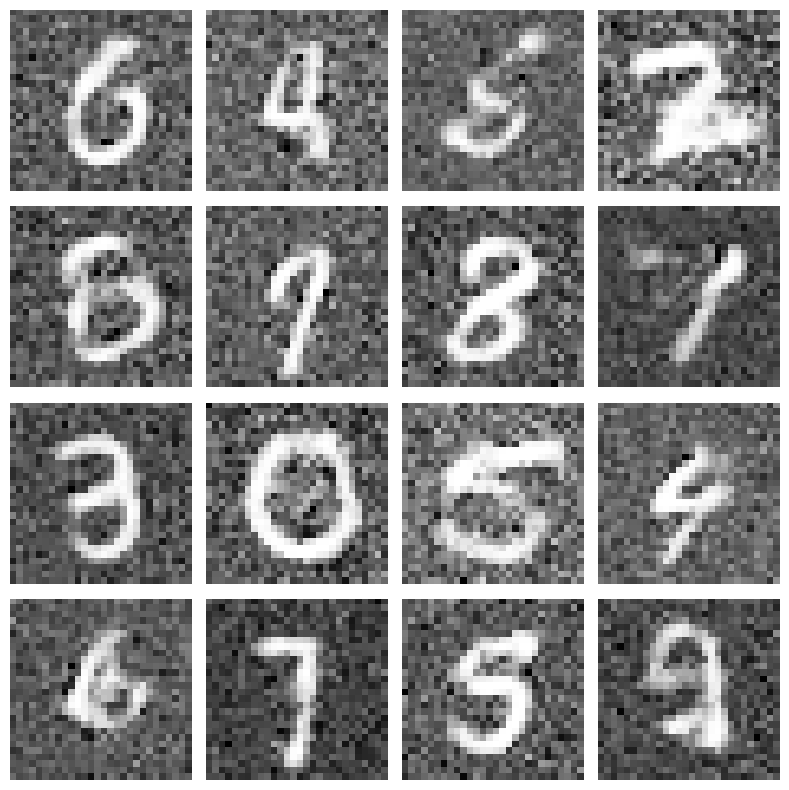

Generated 16 images!


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Parameters
latent_dim = 100  # Must match what you used during training
num_images = 16   # Number of images to generate
image_size = 28   # MNIST image size

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the Generator architecture (must match your training architecture)
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # First layer
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),

            # Second layer
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            # Third layer
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            # Output layer
            nn.Linear(1024, 784),  # 28*28 = 784
            nn.Tanh()  # Output between -1 and 1
        )

    def forward(self, z):
        # Generate images from noise
        img = self.model(z)
        img = img.view(-1, 1, 28, 28)  # Reshape to image dimensions
        return img

# Load the trained generator
generator = Generator(latent_dim).to(device)
try:
    generator.load_state_dict(torch.load('mnist_generator.pth', map_location=device))
    print("Generator model loaded successfully!")
    generator.eval()  # Set to evaluation mode
except Exception as e:
    print(f"Error loading model: {e}")
    exit(1)

# Generate images
def generate_images(num_images=16, grid_size=4):
    """Generate and display a grid of images from the generator."""
    with torch.no_grad():  # No need to track gradients
        # Create random noise vectors
        z = torch.randn(num_images, latent_dim, dtype=torch.float32).to(device)

        # Generate images
        generated = generator(z)

        # Move to CPU and convert to numpy for plotting
        generated = generated.detach().cpu().numpy()

        # Plot the images in a grid
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))

        for i, ax in enumerate(axes.flat):
            if i < num_images:
                # Reshape and scale image for display
                img = generated[i, 0]  # First channel
                ax.imshow(img, cmap='gray')
                ax.axis('off')

        plt.tight_layout()
        plt.savefig('generated_digits.png')
        plt.show()

        return generated

# Generate a batch of images and display them
print("Generating images...")
images = generate_images(num_images=16)
print(f"Generated {len(images)} images!")

# You can also generate a specific number of images
def generate_specific_number(num=10, save=True):
    """Generate a specific number of images."""
    with torch.no_grad():
        z = torch.randn(num, latent_dim, dtype=torch.float32).to(device)
        generated = generator(z)
        generated = generated.detach().cpu().numpy()

        if save:
            # Save individual images
            for i in range(num):
                plt.figure(figsize=(2, 2))
                plt.imshow(generated[i, 0], cmap='gray')
                plt.axis('off')
                plt.savefig(f'digit_{i+1}.png')
                plt.close()

        return generated

# Uncomment to generate and save 10 individual images
# generate_specific_number(10, save=True)